In [1]:
# http://python.jobbole.com/87813/
# https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/

import matplotlib.pyplot as plt   # Import matplotlib
# Control the default size of figures in this Jupyter notebook
%pylab inline
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
import pandas as pd
import pandas_datareader.data as web # Package and modules for importing data; this code may change depending on pandas version
import datetime
import pandas_datareader as pdr


# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date

apple = web.DataReader('AAPL', 'google', start, end)
#apple = pdr.get_data_google('AAPL')
aapl = web.Options('AAPL', 'yahoo')
apple_quote = web.get_quote_google('AAPL')

type(apple)
apple_quote

Populating the interactive namespace from numpy and matplotlib


,change_pct,last,time
AAPL,0.0,147.77,2017-07-13 16:00:00


In [2]:
apple.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,102.61,105.37,102.00,105.35,67281190
2016-01-05,105.75,105.85,102.41,102.71,55790992
2016-01-06,100.56,102.37,99.87,100.70,68457388
2016-01-07,98.68,100.13,96.43,96.45,81094428
2016-01-08,98.55,99.11,96.76,96.96,70798016


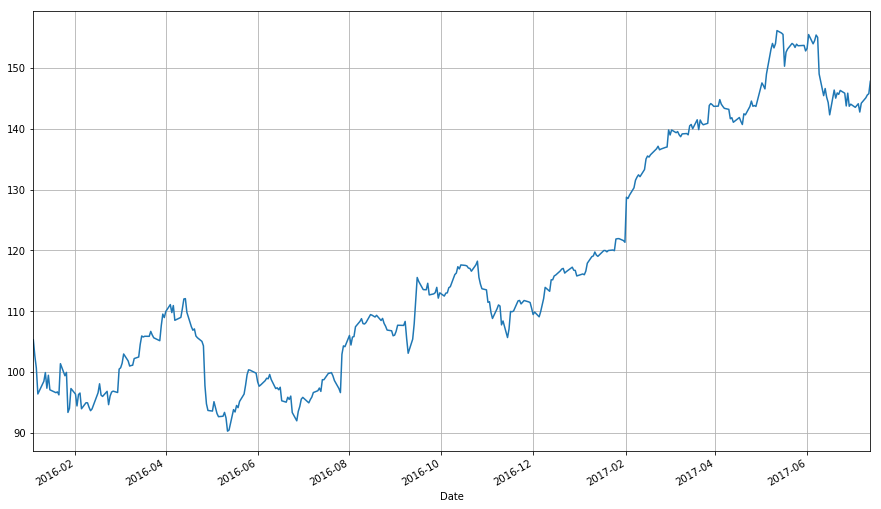

In [3]:
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

apple["Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

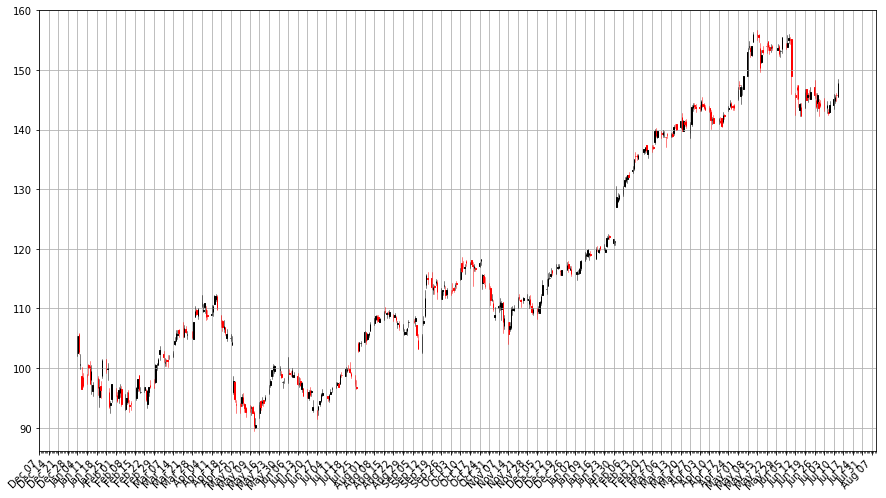

In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

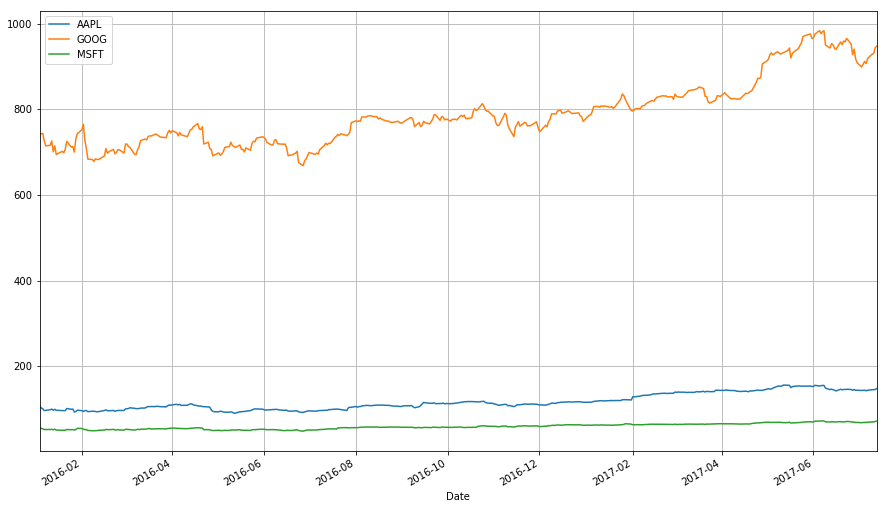

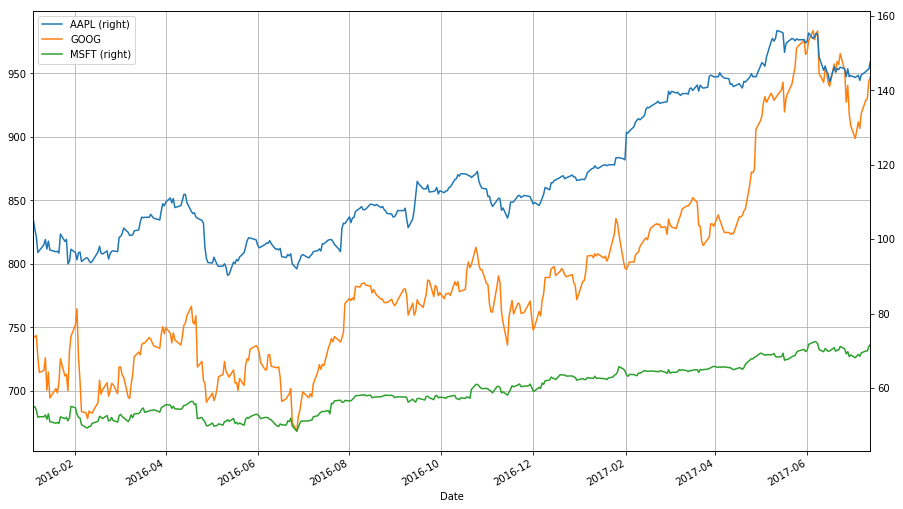

In [5]:
microsoft = web.DataReader("MSFT", "google", start, end)
google = web.DataReader("GOOG", "google", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Close"],
                      "MSFT": microsoft["Close"],
                      "GOOG": google["Close"]})
 
stocks.head()
stocks.plot(grid = True)
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [6]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


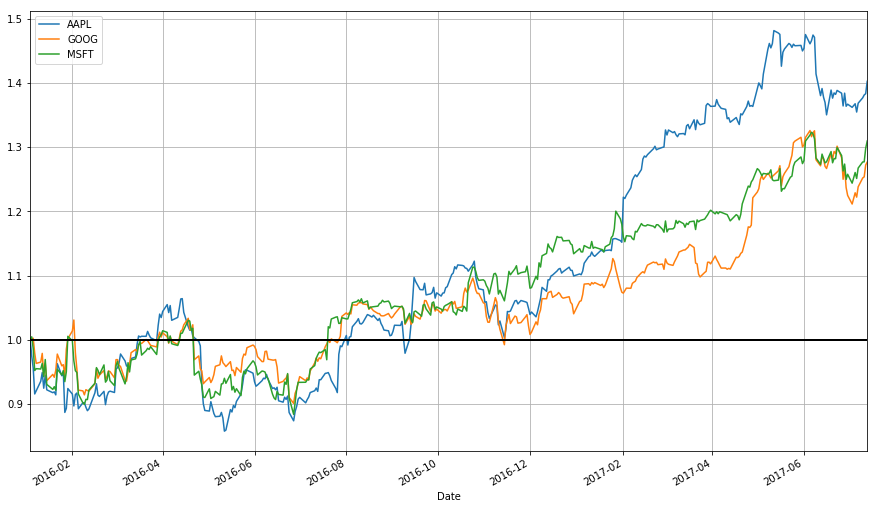

In [7]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

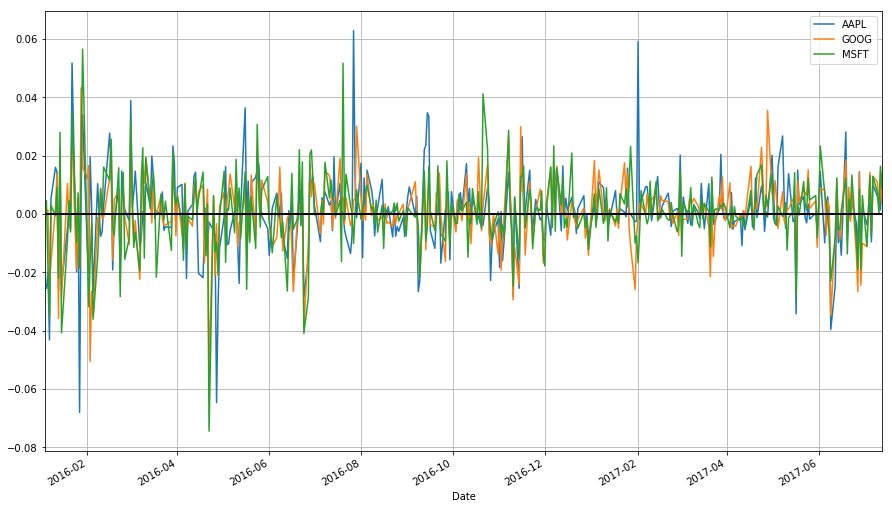

In [8]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

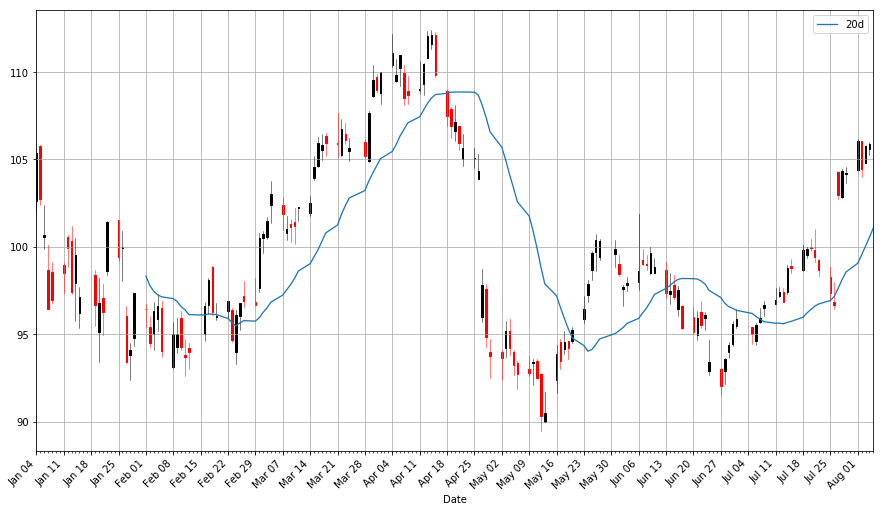

In [9]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2) # 20 days moving average
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

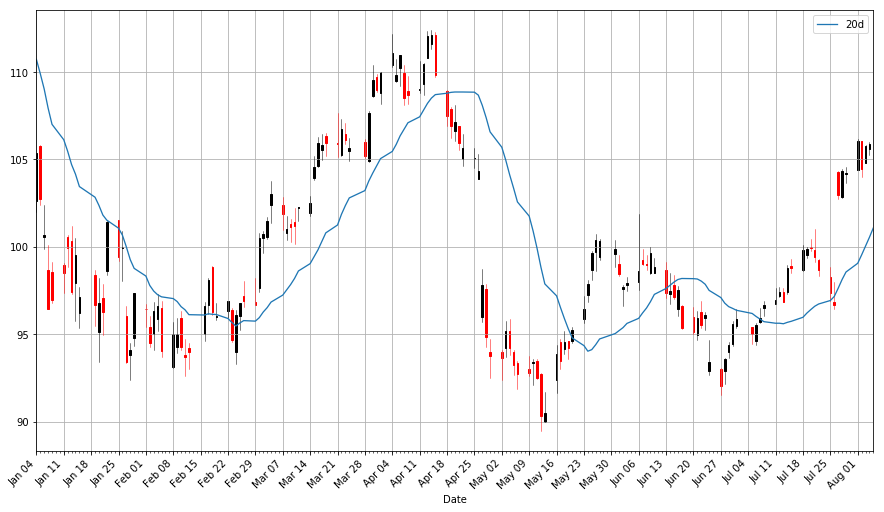

In [10]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader('AAPL', 'google', start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

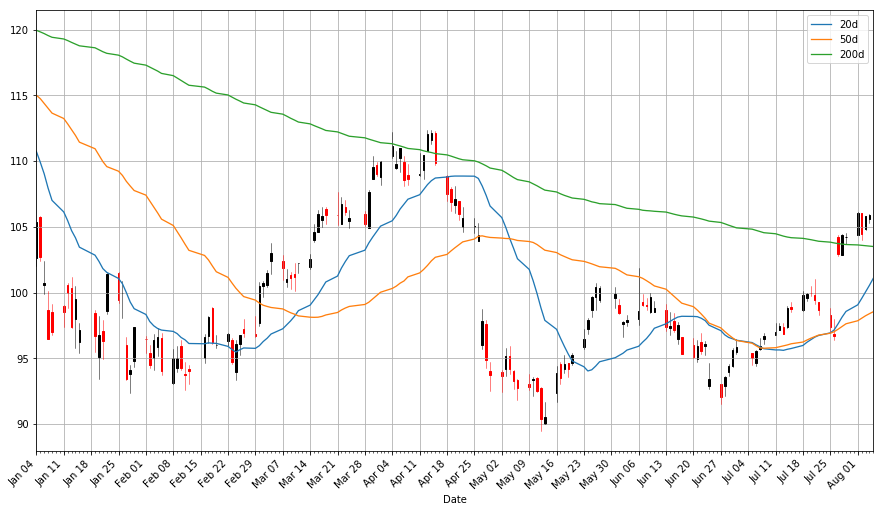

In [11]:
# Also we are interested in other longer period case
# 20-day average fluctuates most, while 200-days gives least.
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])